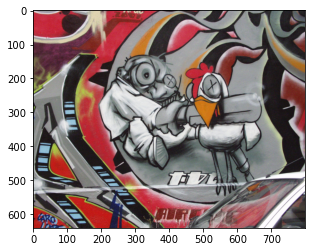

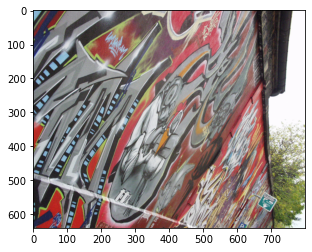

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyrobustac
from time import time

img1 = cv2.cvtColor(cv2.imread('../build/data/graf1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/graf2.png'), cv2.COLOR_BGR2RGB)
H_gt = np.linalg.inv(np.loadtxt('../build/data/homography_graf_1_2.txt'))
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [2]:
#We will detect ORB features and match them with cross-check test
srcPts, dstPts, affines = pyrobustac.extractACs('../build/data/graf1.png', '../build/data/graf2.png')

print(srcPts.shape[0], 'affine correspondences are found.')

98 affine correspondences are found.


In [3]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, img1, img2, mask):
    
    n = kps1.shape[0]
    sourceKeypoints = [cv2.KeyPoint(kps1[i][0], kps1[i][1], 0) for i in np.arange(n)]
    destinationKeypoints = [cv2.KeyPoint(kps2[i][0], kps2[i][1], 0) for i in np.arange(n)]
    tentatives = [cv2.DMatch(i, i, 0) for i in np.arange(n)]
    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),sourceKeypoints,decolorize(img2),destinationKeypoints,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

In [4]:
img1.shape

(640, 800, 3)

13.0 inliers found
0.04185962677001953  sec cv2
91.0 inliers found
0.0029935836791992188  sec gc-ransac with affine correspondences


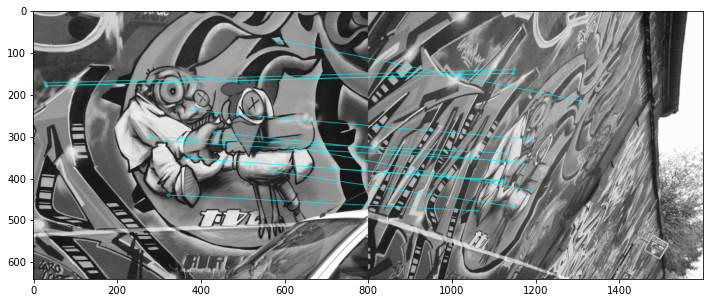

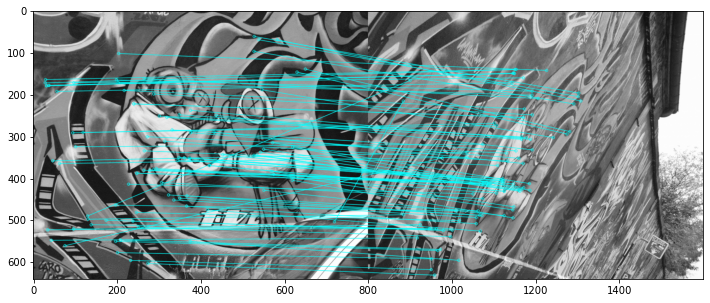

In [7]:
def verify_cv2(kps1, kps2):
    H, mask = cv2.findHomography(kps1, kps2, cv2.RANSAC, 0.5)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask
def verify_pygcransac(kps1, kps2, affines, h1, w1, h2, w2):
    H, mask = pyrobustac.findHomography(
        np.ascontiguousarray(kps1), 
        np.ascontiguousarray(kps2), 
        np.ascontiguousarray(affines), 
        h1, w1, h2, w2, 
        0.5)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return H, mask

t=time()
cv2_H, cv2_mask = verify_cv2(srcPts, dstPts)
print (time()-t, ' sec cv2')
t=time()
ac_H, ac_mask = verify_pygcransac(srcPts, dstPts, affines, img1.shape[0], img1.shape[1], img2.shape[0], img2.shape[1])
print (time()-t, ' sec gc-ransac with affine correspondences')

draw_matches(srcPts, dstPts, img1, img2, cv2_mask)
draw_matches(srcPts, dstPts, img1, img2, ac_mask)
